In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt

import seaborn as sns
import xgboost as xgb

color_pal = sns.color_palette()

/kaggle/input/tabular-playground-series-sep-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-sep-2022/train.csv
/kaggle/input/tabular-playground-series-sep-2022/test.csv


Train data contain 6 countries with 4 shops for every country and 4 products for every shop (6 countries, each have 8 values. For one day we have 48 lines of Data)

In [2]:
InputDataNames = ["date","country","num_sold"] #имена столбцов которые я использую и в тренировочных и в тестовых данных

train_row = pd.read_csv("../input/tabular-playground-series-sep-2022/train.csv", delimiter=",")
test_row = pd.read_csv("../input/tabular-playground-series-sep-2022/test.csv", delimiter=",")

train_row = train_row[InputDataNames] # присвоение данных определенных столбцом
InputDataNames.remove("num_sold") #данные для тестовой выборки не имеют колонки проданых товаров
test_row = test_row[InputDataNames]
InputDataNames.append("num_sold")

train_pd = train_row.copy() #Data = train_row
train_pd = train_pd.set_index('date')
train_pd.index = pd.to_datetime(train_pd.index)

test_pd = test_row.copy() #Data_T = test_pd
test_pd = test_pd.set_index('date')
test_pd.index = pd.to_datetime(test_pd.index)

In [3]:
def create_features(Date): #функция для  создания разных индексов для работы с каждым отрезком времени отдельно
    """
    Create time series features based on time series index.
    """
    Date = Date.copy()
    Date['dayofweek'] = Date.index.dayofweek # 1-7
    Date['quarter'] = Date.index.quarter # 1 - 4 повторяються 4 раза, вроде(сколько лет столько и повторяеться) 
    Date['month'] = Date.index.month # 1 - 12 повторяються 4 раза, вроде(сколько лет столько и повторяеться) 
    Date['year'] = Date.index.year # повторяються 4 раза, вроде(сколько лет столько и повторяеться) 
    Date['dayofyear'] = Date.index.dayofyear #2017 - 2020, 4 значения
    Date['dayofmonth'] = Date.index.day # 1-31 (29-31) 
    Date['weekofyear'] = Date.index.isocalendar().week # 1-52(53) недель в году, повторяються 4 раза,(сколько лет столько и повторяеться) 
   
    return Date

train_pd = create_features(train_pd)
print(train_pd.index.isocalendar().week[47:(48*365*1)])

date
2017-01-01    52
2017-01-02     1
2017-01-02     1
2017-01-02     1
2017-01-02     1
              ..
2017-12-31    52
2017-12-31    52
2017-12-31    52
2017-12-31    52
2017-12-31    52
Name: week, Length: 17473, dtype: UInt32


(1461,)


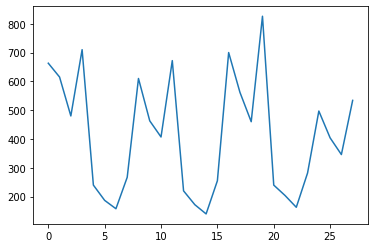

In [4]:
one_day = 48
train_np = train_pd["num_sold"].to_numpy()
Day_sum = np.array([])
train_np.reshape(one_day,int((70128/one_day))) #48 - количество продаж для всех магазинов в один день
for i in range(int((70128/one_day))):
    Day_sum = np.append(Day_sum,[np.sum(train_np[i])])
print(Day_sum.shape)

plt.plot(Day_sum[0:28]) #Не стортированое по дням и странам количество продаж
plt.show()

# **Train** / **Test** 

# Create **HAHAAHHAAHAH MODEL**


In [5]:
train = create_features(train_pd)
test = create_features(test_pd)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year','dayofmonth']#
TARGET = 'num_sold'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
#y_test = test[TARGET]
print(X_test.columns)
print(X_train.columns)

Index(['dayofyear', 'dayofweek', 'quarter', 'month', 'year', 'dayofmonth'], dtype='object')
Index(['dayofyear', 'dayofweek', 'quarter', 'month', 'year', 'dayofmonth'], dtype='object')


In [6]:
reg = xgb.XGBRegressor(base_score=0.1, booster='gbtree',    
                       n_estimators=400,
                       objective='reg:squarederror',
                       max_depth=5,
                       learning_rate=0.02)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=50)

[0]	validation_0-rmse:228.67124
[50]	validation_0-rmse:142.12842
[100]	validation_0-rmse:126.13989
[150]	validation_0-rmse:123.80008
[200]	validation_0-rmse:123.45224
[250]	validation_0-rmse:123.38697
[300]	validation_0-rmse:123.36289
[350]	validation_0-rmse:123.35022
[399]	validation_0-rmse:123.34211


XGBRegressor(base_score=0.1, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

# **Feature** **Importance**

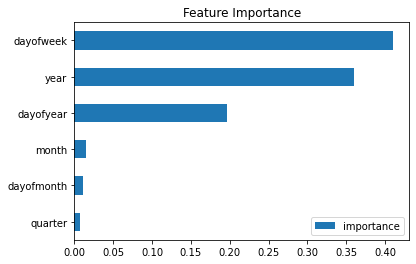

In [7]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# **Forecast** on Test

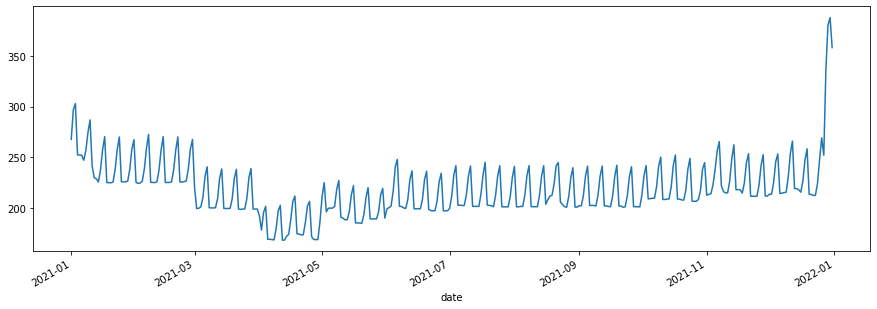

(17520,)
date
2021-01-01    267.762207
2021-01-01    267.762207
2021-01-01    267.762207
2021-01-01    267.762207
2021-01-01    267.762207
                 ...    
2021-12-31    358.224182
2021-12-31    358.224182
2021-12-31    358.224182
2021-12-31    358.224182
2021-12-31    358.224182
Name: prediction, Length: 17520, dtype: float32


In [8]:
test['prediction'] = reg.predict(X_test)
train_pd = train_pd.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = test["prediction"].plot(figsize=(15, 5))
plt.show()
print(test['prediction'].shape)
print(test['prediction'])
test['prediction'].to_csv("Version 1", sep=',')